# Single-cell RNA-seq analysis — mouse rectal tissue

This notebook contains exploratory single-cell RNA-seq analysis of mouse rectal tissue using Scanpy
and related tools. It walks through data loading, quality control, preprocessing, dimensionality reduction,
clustering, marker discovery, and pseudobulk-based pathway / activity analysis using `decoupler`.

The goal is to demonstrate a full analysis pipeline suitable for a portfolio / PhD application:

1. Inspect and QC cells
2. Normalise, find highly variable genes, and scale
3. Compute PCA, neighbours, UMAP and Leiden clusters
4. Identify marker genes per cluster
5. Aggregate cells into pseudobulk profiles and perform downstream analyses with `decoupler`


# 1. Setup and library imports
Load the raw single-cell AnnData object and metadata required for downstream processing.

In [ ]:
!pip install scanpy anndata decoupler celltypist pandas numpy matplotlib seaborn

In [42]:
import scanpy as sc
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# 2. Load single-cell data (mouse rectal tissue)

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')  # commented out for GitHub; update paths as needed

In [45]:
adata = sc.read("data/colab_notebooks/single_cell_data_mouce_gut/adata_merged_processed.h5ad")
metadata = pd.read_csv("data/colab_notebooks/single_cell_data_mouce_gut/sample_metadata.csv")

In [46]:
adata.obs_names

Index(['AAACCCAAGATTAGCA-1-ALV5070A4_Oct2022',
       'AAACCCAAGGCCGCTT-1-ALV5070A4_Oct2022',
       'AAACCCAGTGCTCCGA-1-ALV5070A4_Oct2022',
       'AAACCCATCCTTATGT-1-ALV5070A4_Oct2022',
       'AAACGAACACAAATGA-1-ALV5070A4_Oct2022',
       'AAACGAAGTGCTGATT-1-ALV5070A4_Oct2022',
       'AAACGAAGTTGTCCCT-1-ALV5070A4_Oct2022',
       'AAACGAATCCCGAACG-1-ALV5070A4_Oct2022',
       'AAACGAATCTTTGGAG-1-ALV5070A4_Oct2022',
       'AAACGCTAGGGAGGAC-1-ALV5070A4_Oct2022',
       ...
       'TTTGGAGTCATTTCCA-1-ALV5070A3_Oct2022',
       'TTTGGTTAGGCGATAC-1-ALV5070A3_Oct2022',
       'TTTGGTTAGGTTACCT-1-ALV5070A3_Oct2022',
       'TTTGGTTCAGAACCGA-1-ALV5070A3_Oct2022',
       'TTTGGTTGTCGCCTAG-1-ALV5070A3_Oct2022',
       'TTTGGTTGTTCCTAAG-1-ALV5070A3_Oct2022',
       'TTTGGTTTCGAGCCAC-1-ALV5070A3_Oct2022',
       'TTTGGTTTCGGTCAGC-1-ALV5070A3_Oct2022',
       'TTTGTTGAGCGCCCAT-1-ALV5070A3_Oct2022',
       'TTTGTTGCAATACGAA-1-ALV5070A3_Oct2022'],
      dtype='object', length=60488)

In [47]:
adata.var_names[0:10]

Index(['0610005C13Rik', '0610009B22Rik', '0610009O20Rik', '0610010F05Rik',
       '0610010K14Rik', '0610012G03Rik', '0610025J13Rik', '0610030E20Rik',
       '0610031O16Rik', '0610033M10Rik'],
      dtype='object')

In [48]:
adata.obs[['sample', 'total_counts', 'pct_counts_in_top_20_genes']]

,sample,total_counts,pct_counts_in_top_20_genes
AAACCCAAGATTAGCA-1-ALV5070A4_Oct2022,ALV5070A4_Oct2022,1481.0,30.249831
AAACCCAAGGCCGCTT-1-ALV5070A4_Oct2022,ALV5070A4_Oct2022,14719.0,86.819757
AAACCCAGTGCTCCGA-1-ALV5070A4_Oct2022,ALV5070A4_Oct2022,11990.0,12.643870
AAACCCATCCTTATGT-1-ALV5070A4_Oct2022,ALV5070A4_Oct2022,2639.0,33.383858
AAACGAACACAAATGA-1-ALV5070A4_Oct2022,ALV5070A4_Oct2022,725.0,38.068966
...,...,...,...
TTTGGTTGTTCCTAAG-1-ALV5070A3_Oct2022,ALV5070A3_Oct2022,18378.0,23.549897
TTTGGTTTCGAGCCAC-1-ALV5070A3_Oct2022,ALV5070A3_Oct2022,32894.0,14.628808
TTTGGTTTCGGTCAGC-1-ALV5070A3_Oct2022,ALV5070A3_Oct2022,6288.0,15.632952
TTTGTTGAGCGCCCAT-1-ALV5070A3_Oct2022,ALV5070A3_Oct2022,4380.0,19.429224


In [49]:
adata

AnnData object with n_obs × n_vars = 60488 × 20886
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'doublet_score', 'predicted_doublet'

In [50]:
metadata_df = pd.read_csv ("data/colab_notebooks/single_cell_data_mouce_gut/sample_metadata.csv")

In [51]:
adata.obs = adata.obs.merge(metadata_df, on='sample', how='left')

In [52]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 136516859 stored elements and shape (60488, 20886)>

In [53]:
adata.X.data.min(), adata.X.data.max()

(np.float32(1.0), np.float32(56332.0))

In [54]:
adata[:, :].X.data.mean()

np.float32(4.8244257)

In [55]:
adata.obs_names[0]

'0'

In [56]:
adata.var_names[-1]

'mt-Nd6'

In [57]:
adata.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier,doublet_score,predicted_doublet,Condition,Species,Tissue,NA_Column,Location,Genotype,Infection_Status
0,ALV5070A4_Oct2022,793,6.677083,1481.0,7.301148,30.249831,143.0,4.969813,9.655638,False,0.040831,False,Prdm1fl/fl Maf fl/fl Cd4Cre_Infected.1,Mus musculus,colon lamina propria,NaN,colon LPL,Prdm1fl/fl Maf fl/fl Cd4Cre,Infected
1,ALV5070A4_Oct2022,1182,7.075809,14719.0,9.596962,86.819757,558.0,6.326149,3.791018,False,0.063116,False,Prdm1fl/fl Maf fl/fl Cd4Cre_Infected.1,Mus musculus,colon lamina propria,NaN,colon LPL,Prdm1fl/fl Maf fl/fl Cd4Cre,Infected
2,ALV5070A4_Oct2022,3273,8.093768,11990.0,9.391912,12.643870,345.0,5.846439,2.877398,False,0.044776,False,Prdm1fl/fl Maf fl/fl Cd4Cre_Infected.1,Mus musculus,colon lamina propria,NaN,colon LPL,Prdm1fl/fl Maf fl/fl Cd4Cre,Infected
3,ALV5070A4_Oct2022,1164,7.060476,2639.0,7.878534,33.383858,338.0,5.826000,12.807882,False,0.042748,False,Prdm1fl/fl Maf fl/fl Cd4Cre_Infected.1,Mus musculus,colon lamina propria,NaN,colon LPL,Prdm1fl/fl Maf fl/fl Cd4Cre,Infected
4,ALV5070A4_Oct2022,400,5.993961,725.0,6.587550,38.068966,177.0,5.181784,24.413794,False,0.063116,False,Prdm1fl/fl Maf fl/fl Cd4Cre_Infected.1,Mus musculus,colon lamina propria,NaN,colon LPL,Prdm1fl/fl Maf fl/fl Cd4Cre,Infected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60483,ALV5070A3_Oct2022,4056,8.308199,18378.0,9.818964,23.549897,600.0,6.398595,3.264773,False,0.071359,False,Prdm1fl/fl Maf fl/fl_Infected.1,Mus musculus,colon lamina propria,NaN,colon LPL,Prdm1fl/fl Maf fl/fl,Infected
60484,ALV5070A3_Oct2022,5544,8.620652,32894.0,10.401076,14.628808,1592.0,7.373374,4.839788,False,0.071359,False,Prdm1fl/fl Maf fl/fl_Infected.1,Mus musculus,colon lamina propria,NaN,colon LPL,Prdm1fl/fl Maf fl/fl,Infected
60485,ALV5070A3_Oct2022,2480,7.816417,6288.0,8.746557,15.632952,108.0,4.691348,1.717557,False,0.071359,False,Prdm1fl/fl Maf fl/fl_Infected.1,Mus musculus,colon lamina propria,NaN,colon LPL,Prdm1fl/fl Maf fl/fl,Infected
60486,ALV5070A3_Oct2022,1730,7.456455,4380.0,8.385033,19.429224,310.0,5.739793,7.077625,False,0.025641,False,Prdm1fl/fl Maf fl/fl_Infected.1,Mus musculus,colon lamina propria,NaN,colon LPL,Prdm1fl/fl Maf fl/fl,Infected


High mitochondrial percentage indicates stressed or dying cells that should be filtered out. (except for mitochondrial focused studies)

In [58]:
adata = sc.read("data/colab_notebooks/single_cell_data_mouce_gut/adata_merged_processed.h5ad")

In [59]:
adata.var_names.str.startswith("mt-").sum()

np.int64(13)

In [60]:
adata.var ["mt"]= adata.var_names.str.startswith("mt-")

In [61]:
adata.var['mt'].value_counts()

,count
mt,
False,20873
True,13


# 3. Quality control and preprocessing
Remove poor-quality cells and low-information genes to prevent technical noise from driving downstream structure.

In [62]:
sc.pp.calculate_qc_metrics

<function scanpy.preprocessing._qc.calculate_qc_metrics(adata: 'AnnData', *, expr_type: 'str' = 'counts', var_type: 'str' = 'genes', qc_vars: 'Collection[str] | str' = (), percent_top: 'Collection[int] | None' = (50, 100, 200, 500), layer: 'str | None' = None, use_raw: 'bool' = False, inplace: 'bool' = False, log1p: 'bool' = True, parallel: 'bool | None' = None) -> 'tuple[pd.DataFrame, pd.DataFrame] | None'>

In [63]:
sc.pp.calculate_qc_metrics (adata,
                            qc_vars=['mt'],
                                     inplace=True,
                                     percent_top= [20],log1p=True)

In [64]:
adata

AnnData object with n_obs × n_vars = 60488 × 20886
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [65]:
import seaborn as sns

###  3.1 Plotting and Visualization

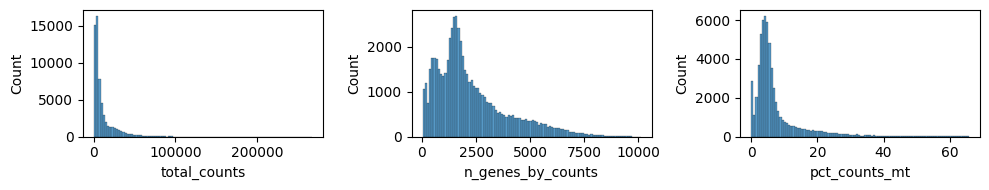

In [66]:
fig, axes = plt.subplots(1,3,figsize=(10,2))
sns.histplot(adata.obs['total_counts'], bins= 100, kde= False, ax=axes[0])
sns.histplot(adata.obs['n_genes_by_counts'], bins= 100, kde= False, ax=axes[1])
sns.histplot(adata.obs['pct_counts_mt'], bins= 100, kde= False, ax=axes[2])
plt.tight_layout()
plt.savefig('mt_graph')

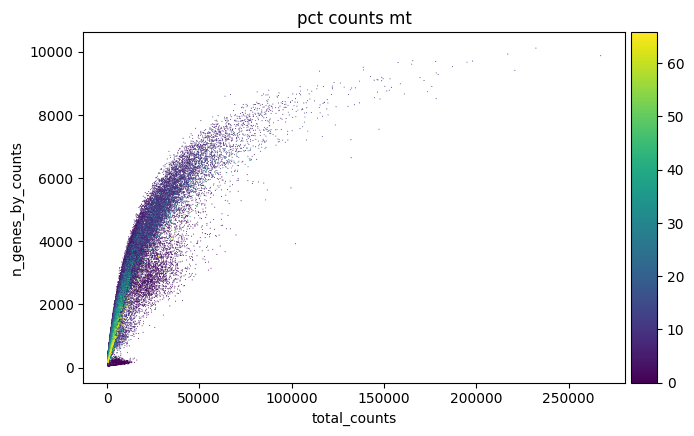

In [67]:
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")


### 3.2 Doublet
Detect and remove doublets to avoid artificial hybrid cell profiles created during droplet capture (10x Chromium).

In [68]:
adata= sc.read('data/colab_notebooks/single_cell_data_mouce_gut/adata_merged_processed.h5ad')
adata.obs['sample'].value_counts()

,count
sample,
ALV5070A7_Oct2022,5828
ALV5070A9_Oct2022,4227
ALV5070A3_Oct2022,4148
ALV5070A10_Oct2022,4034
ALV5070A6_Oct2022,3932
ALV5070A1_Oct2022,3897
ALV5070A8_Oct2022,3768
ALV5070A14_Oct2022,3767
ALV5070A13_Oct2022,3764


In [69]:
adata= sc.read('data/colab_notebooks/single_cell_data_mouce_gut/adata_merged_processed.h5ad')
adata.obs['sample'].value_counts()
adata = adata[adata.obs['sample'] == 'ALV5070A4_Oct2022']
adata

View of AnnData object with n_obs × n_vars = 3393 × 20886
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'doublet_score', 'predicted_doublet'

In [70]:
adata

View of AnnData object with n_obs × n_vars = 3393 × 20886
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'doublet_score', 'predicted_doublet'

In [71]:
sc.pp.filter_cells(adata,min_counts=728)
adata

AnnData object with n_obs × n_vars = 3259 × 20886
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'doublet_score', 'predicted_doublet', 'n_counts'

In [72]:
sc.pp.scrublet(adata)

In [73]:
import skimage

In [74]:
adata.obs['predicted_doublet'].sum()

np.int64(2)

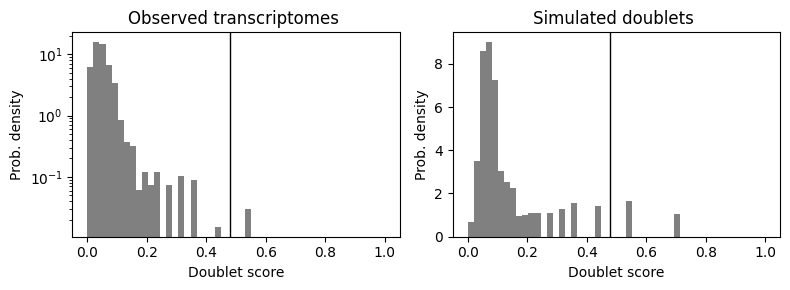

In [75]:
sc.pl.scrublet_score_distribution(adata)

In [76]:
adata[adata.obs['predicted_doublet'] !=True]

View of AnnData object with n_obs × n_vars = 3257 × 20886
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'doublet_score', 'predicted_doublet', 'n_counts'
    uns: 'scrublet'

In [77]:
adata[adata.obs['predicted_doublet'] !=True].copy()

AnnData object with n_obs × n_vars = 3257 × 20886
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'doublet_score', 'predicted_doublet', 'n_counts'
    uns: 'scrublet'

### 3.3 Dimentionality reduction

In [78]:
adata = sc.read_h5ad("data/colab_notebooks/single_cell_data_mouce_gut/adata_merged_processed.h5ad")

In [79]:
adata.layers['counts'] = adata.X.copy()

### 3.4 Normalization: 
Scale each cell to the same total counts to make expression levels comparable across cells.

In [80]:
sc.pp.normalize_total(adata)

In [81]:
print(adata.layers['counts'][0].sum(), adata.layers['counts'] [1].sum())

1481.0 14719.0


### 3.4 Log Transformation:
Compress large value ranges and stabilise variance, allowing PCA and clustering to work effectively.

In [82]:
sc.pp.log1p(adata)

In [83]:
sc.pp.highly_variable_genes(adata, batch_key="sample", flavor="seurat", n_top_genes=2000)

### 3.5 Highly Variable Genes (HVGs):
Select the most informative genes that drive biological variation while reducing noise from uninformative genes.

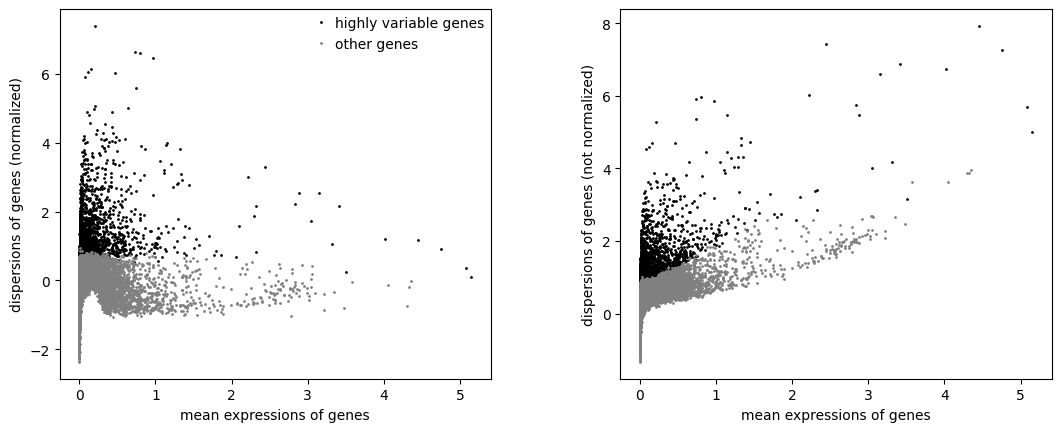

In [84]:
sc.pl.highly_variable_genes(adata)

# 4. Clustering
Detect transcriptionally coherent groups of cells, representing putative biological cell types or states

In [85]:
import skimage

In [86]:
sc.tl.pca(adata)

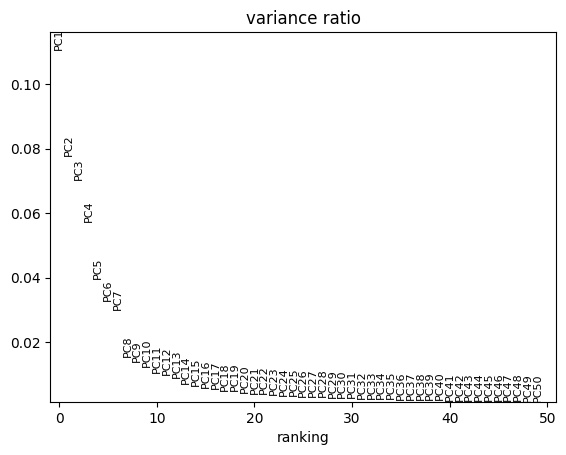

In [87]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=False)

In [88]:
sc.pp.neighbors(adata)

In [89]:
sc.tl.umap(adata)

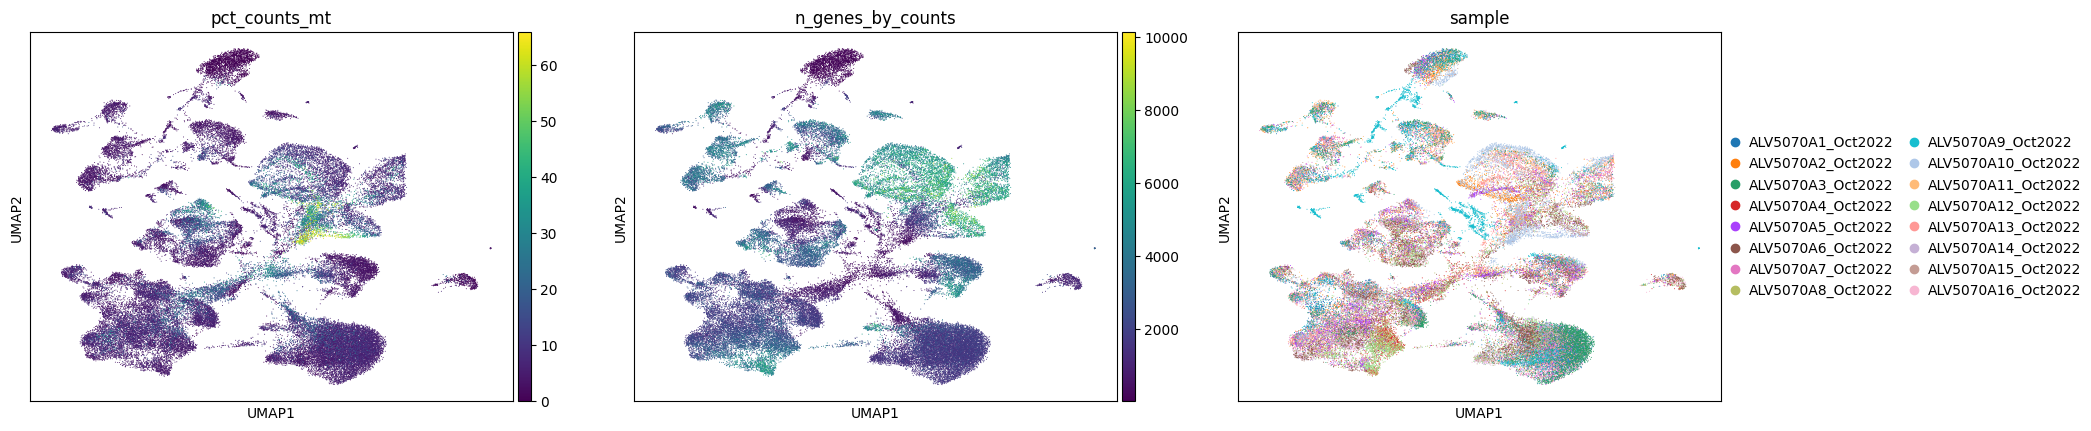

In [90]:
sc.pl.umap(adata, color=['pct_counts_mt','n_genes_by_counts', 'sample'])

### 4.1 Cell annotations

In [91]:
import celltypist

In [92]:
adata= sc.read('data/colab_notebooks/single_cell_data_mouce_gut/adata_merged_processed.h5ad')
adata.obs['sample'].value_counts()
adata = adata[adata.obs['sample'] == 'ALV5070A4_Oct2022']
adata


View of AnnData object with n_obs × n_vars = 3393 × 20886
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'doublet_score', 'predicted_doublet'

In [93]:
celltypist.models.models_description()[0:10]

,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from C...
3,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
4,Adult_Human_MTG.pkl,cell types and subtypes (10x-based) from the a...
5,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
6,Adult_Human_PrefrontalCortex.pkl,cell types and subtypes from the adult human d...
7,Adult_Human_Skin.pkl,cell types from human healthy adult skin
8,Adult_Human_Vascular.pkl,vascular populations combined from multiple ad...
9,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...


In [94]:
celltypist.models.download_models('Adult_Mouse_Gut.pkl')

In [95]:
model = celltypist.models.download_models('Adult_Mouse_Gut.pkl')

In [96]:
print(adata.layers)
adata.X.sum(axis=1) # to chek normalisation to 10000

LayersView with keys: 


matrix([[ 1481.],
        [14719.],
        [11990.],
        ...,
        [29273.],
        [ 4573.],
        [32034.]], dtype=float32)

In [97]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
adata.X.sum(axis=1)

matrix([[10000.],
        [10000.],
        [10000.],
        ...,
        [10000.],
        [10000.],
        [10000.]], dtype=float32)

In [98]:
sc.pp.log1p(adata)
adata.layers['log-nnorm10k'] = adata.X
sc.tl.pca(adata)

In [99]:
## sc.pp.scale(adata)

#### 4.2 Scaling:
Standardise gene values (mean 0, variance 1) so no single gene dominates PCA due to raw magnitude.

In [100]:
predictions = celltypist.annotate(adata, model=model, majority_voting=True)

In [101]:
adata.obs[["celltypist_labels", "over_clustering", "majority_voting"]] = (predictions.predicted_labels)
adata.obs["celltypist_confidence"] = predictions.probability_matrix.max(axis=1)

In [102]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
AAACCCAAGATTAGCA-1-ALV5070A4_Oct2022,Fibroblasts,0,Double-positive thymocytes
AAACCCAAGGCCGCTT-1-ALV5070A4_Oct2022,Double-positive thymocytes,1,Double-positive thymocytes
AAACCCAGTGCTCCGA-1-ALV5070A4_Oct2022,Double-positive thymocytes,2,Double-positive thymocytes
AAACCCATCCTTATGT-1-ALV5070A4_Oct2022,Double-positive thymocytes,4,Double-positive thymocytes
AAACGAACACAAATGA-1-ALV5070A4_Oct2022,Double-positive thymocytes,7,Double-positive thymocytes
...,...,...,...
TTTGGTTTCTCATGGA-1-ALV5070A4_Oct2022,Epithelial cells,32,Double-positive thymocytes
TTTGGTTTCTCTAGGA-1-ALV5070A4_Oct2022,Double-positive thymocytes,7,Double-positive thymocytes
TTTGTTGAGGCTTTCA-1-ALV5070A4_Oct2022,Epithelial cells,46,Epithelial cells
TTTGTTGCAGTGTGGA-1-ALV5070A4_Oct2022,Double-positive thymocytes,9,Double-positive thymocytes


In [103]:
predictions.probability_matrix

,Age-associated B cells,Alveolar macrophages,B cells,CD16+ NK cells,CD16- NK cells,CD8a/a,CD8a/b(entry),CMP,CRTAM+ gamma-delta T cells,Classical monocytes,...,Transitional B cells,Transitional DC,Transitional NK,Treg(diff),Trm cytotoxic T cells,Type 1 helper T cells,Type 17 helper T cells,gamma-delta T cells,pDC,pDC precursor
AAACCCAAGATTAGCA-1-ALV5070A4_Oct2022,0.000449,0.001382,0.000301,0.000680,0.000500,0.000384,0.000276,0.000615,0.000384,0.000787,...,0.000540,0.000330,0.000538,0.000417,0.000710,0.000281,0.000360,0.000538,0.000441,0.000383
AAACCCAAGGCCGCTT-1-ALV5070A4_Oct2022,0.000293,0.000817,0.000250,0.000452,0.000329,0.000229,0.000324,0.000303,0.000264,0.000539,...,0.000302,0.000278,0.000286,0.000296,0.000298,0.000283,0.000252,0.000322,0.000321,0.000263
AAACCCAGTGCTCCGA-1-ALV5070A4_Oct2022,0.000293,0.000817,0.000250,0.000452,0.000329,0.000229,0.000324,0.000303,0.000264,0.000539,...,0.000302,0.000278,0.000286,0.000296,0.000298,0.000283,0.000252,0.000322,0.000321,0.000263
AAACCCATCCTTATGT-1-ALV5070A4_Oct2022,0.000293,0.000817,0.000250,0.000452,0.000329,0.000229,0.000324,0.000303,0.000264,0.000539,...,0.000302,0.000278,0.000286,0.000296,0.000298,0.000283,0.000252,0.000322,0.000321,0.000263
AAACGAACACAAATGA-1-ALV5070A4_Oct2022,0.000293,0.000817,0.000250,0.000452,0.000329,0.000229,0.000324,0.000303,0.000264,0.000539,...,0.000302,0.000278,0.000286,0.000296,0.000298,0.000283,0.000252,0.000322,0.000321,0.000263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCTCATGGA-1-ALV5070A4_Oct2022,0.000458,0.001127,0.000368,0.000429,0.000382,0.000227,0.000436,0.000368,0.000406,0.000464,...,0.000444,0.000521,0.000465,0.000446,0.000248,0.000485,0.000217,0.000384,0.000433,0.000291
TTTGGTTTCTCTAGGA-1-ALV5070A4_Oct2022,0.000293,0.000817,0.000250,0.000452,0.000329,0.000229,0.000324,0.000303,0.000264,0.000539,...,0.000302,0.000278,0.000286,0.000296,0.000298,0.000283,0.000252,0.000322,0.000321,0.000263
TTTGTTGAGGCTTTCA-1-ALV5070A4_Oct2022,0.000377,0.000980,0.000311,0.000439,0.000358,0.000228,0.000383,0.000339,0.000337,0.000495,...,0.000376,0.000396,0.000376,0.000373,0.000269,0.000384,0.000232,0.000355,0.000380,0.000279
TTTGTTGCAGTGTGGA-1-ALV5070A4_Oct2022,0.000293,0.000817,0.000250,0.000452,0.000329,0.000229,0.000324,0.000303,0.000264,0.000539,...,0.000302,0.000278,0.000286,0.000296,0.000298,0.000283,0.000252,0.000322,0.000321,0.000263


In [104]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

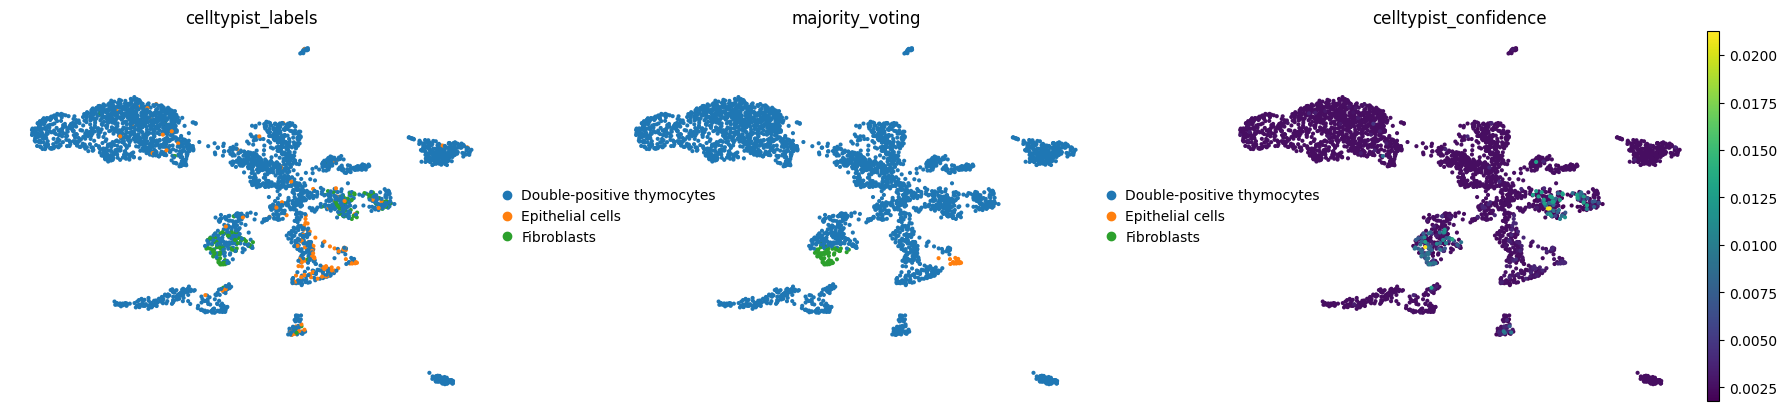

(None,)

In [105]:
sc.pl.umap(adata, color=["celltypist_labels", "majority_voting", "celltypist_confidence"],
           title = ["celltypist_labels", "majority_voting", "celltypist_confidence"],
           frameon = False),

# 5. Pseudobulk generation 
pathway analysis with decoupler
Below we aggregate single cells to pseudobulk profiles and perform downstream analysis using decoupler.

In [2]:
import scanpy as sc
import pandas as pd
import decoupler as dc

In [3]:
# read in adata
adata = sc.read('data/colab_notebooks/single_cell_data_mouce_gut/adata_merged_processed.h5ad')

#read in metadata
metadata= pd.read_csv('data/colab_notebooks/single_cell_data_mouce_gut/sample_metadata.csv')

### 5.1 Merge metadata with anndata

In [4]:
metadata.shape

(16, 8)

In [ ]:
adata.obs= pd.merge(adata.obs, metadata, on='sample')

In [6]:
adata.layers["counts"] = adata.X.copy()

In [7]:
import decoupler as dc

In [8]:
adata_pb = adata.copy() # Work on a copy so we don't break the main adata

##### Preserve unmodified raw counts in adata.layers["counts"] to enable pseudobulk and pathway analysis later.

In [9]:
adata_pb.X = adata_pb.layers["counts"].copy()  # Use raw counts for pseudobulk

In [10]:

adata_pb.obs["group"] = "all_cells" # 2. Create a grouping column: all cells in a sample go into one group

In [11]:

pdata = dc.pp.pseudobulk(
    adata=adata_pb,        # Generate pseudobulk: 1 profile per sample
    sample_col="sample",   # sample ID column from metadata
    groups_col="group",    # 'all_cells' for everyone
    mode="sum",            # sum raw counts
)


#### 5.2 PCA (Dimensionality Reduction)

Capture the major axes of variation in the dataset and remove noise

In [12]:

sc.pp.normalize_total(pdata, target_sum=1e6)   # Normalise and log-transform pseudobulk data
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)

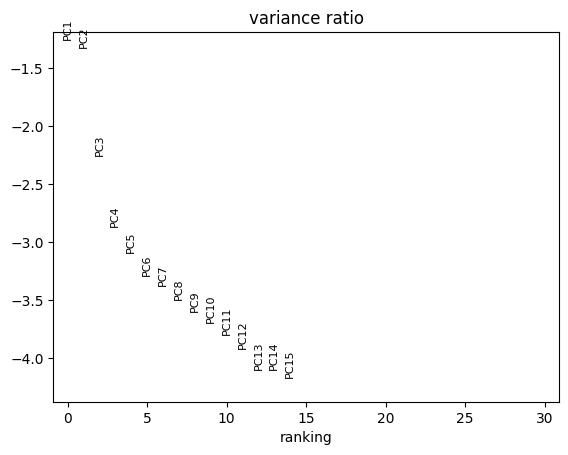

In [13]:

sc.tl.pca(pdata)   # Pseudobulk PCA: sample-level variance in mouse rectal tissue
sc.pl.pca_variance_ratio(pdata, log=True)


##### This PCA is computed on pseudobulk profiles, where raw counts were summed per sample and log-normalised. Each point represents one mouse rectal sample, and PC1 captures the main overall difference between samples, while PC2 and PC3 represent smaller, secondary sources of variation in the transcriptome.